In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import time
import numpy as np
from datetime import datetime
import yfinance as yf
import os
import glob
import regex as re
import csv
import statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [12]:
def remove_none_types(mydf):
    if mydf.isnull().values.any():
        return False
    else:
        return True

X_data = []
Y_data = []

sectors = ["banks"]
for sector in sectors:
    filelist = os.listdir("../sectors/"+sector)
    try:
        filelist.remove('.DS_Store')
    except:
        pass

    for stock in filelist:
        sector_files = glob.glob('../sectors/'+str(sector)+'/'+str(stock)+'/'+str(stock)+'20*[0-9]**[0-9]*[1-4].*')
        sector_files.sort(reverse=True)

        testpath = sector_files[0]
        testdata_from_csv = pd.read_csv(testpath)
        try:
            market_cap = float(testdata_from_csv.iloc[[-1]].values[0][0])
            if (market_cap > 1000000000) and (market_cap < 8000000000):
                for i in range(0, len(sector_files)): # for every .csv path of that stock
                    path = sector_files[i]
                    data_from_csv = pd.read_csv(path)
                    Checks_None = remove_none_types(data_from_csv)
                    if (Checks_None == True):
                        single_X_data = (np.array((data_from_csv[3:73].astype(float))).flatten()) 
                        if (single_X_data.shape[0]) == 70:
                            X_data.append(single_X_data)
                            single_Y_data = np.array(data_from_csv[85:95].astype(float)).flatten()
                            Y_data.append(single_Y_data)
        except:
            pass


X_data_ORIGINAL = np.array(X_data)
Y_data_ORIGINAL = np.array(Y_data)

# # Y_data = Y_data[:,8]



In [13]:
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)
X_data

array([[-0.28631437,  0.0041063 , -0.20368676, ..., -0.61878825,
        -0.75530984, -0.2415555 ],
       [-0.21464566, -0.25666298, -0.4588572 , ..., -0.61878825,
        -0.75530984, -0.2415555 ],
       [ 0.04275175, -0.73940632, -0.39684479, ...,  0.17155808,
         0.07780672, -0.2415555 ],
       ...,
       [ 0.57736983, -1.27476762, -1.17781067, ..., -0.61878825,
        -0.75530984, -0.2415555 ],
       [ 0.0364998 , -0.42466556, -0.38437103, ..., -0.61878825,
        -0.75530984, -0.2415555 ],
       [-0.16478254,  0.20034732, -0.0218059 , ...,  2.54086177,
         2.57715639, -0.2415555 ]])

In [14]:
Y_data = Y_data_ORIGINAL[:,4]

In [146]:
Y_dataCOPY = Y_data.copy()
df = pd.DataFrame(Y_dataCOPY)


# df[0] = np.where(df[0] < -0.4, -2,
#     np.where((df[0] >= -0.4) & (df[0] < -0.07), -1,
#     np.where((df[0] >= -0.07) & (df[0] <= 0.07), 0,
#     np.where((df[0] > 0.07) & (df[0] <= 0.4), 1, 2))))

df[0] = np.where(df[0] < 0.1, 0, 1)

    
Y_data_update = df.to_numpy()

print(Y_data_update.shape)


(535, 1)


In [15]:
Y_data.shape

(2036,)

In [16]:

# scaler = StandardScaler()
# X_data_update = scaler.fit_transform(X_data_update)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.33, random_state=42)
Y_train.shape


(1364,)

In [17]:

    

# Example usage


# Example usage
n_bins = 2 # number of bins

# Divide the data into n_bins intervals using quantiles
bin_edges = np.quantile(Y_data, np.linspace(0, 1, n_bins + 1))
# Assign each data point to a specific bin based on its value
bin_indices = np.digitize(Y_data, bin_edges) - 1
# Make sure the indices are within the range of the number of bins
bin_indices = np.minimum(bin_indices, n_bins - 1)
# Label each bin with a categorical label
bin_labels = ["bin_{}".format(i + 1) for i in range(n_bins)]
# Transform the continuous Y_data into a categorical variable
Y_categorical = np.array([bin_labels[i] for i in bin_indices])



Y_categorical

array(['bin_1', 'bin_2', 'bin_1', ..., 'bin_1', 'bin_2', 'bin_2'],
      dtype='<U5')

In [19]:
for i in range(n_bins):
    print("Bin {}: [{}, {}]".format(i + 1, bin_edges[i], bin_edges[i + 1]))

Bin 1: [-0.5775228317868977, 0.02044623326975148]
Bin 2: [0.02044623326975148, 1.5163936061743124]


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_categorical, test_size=0.33, random_state=42)


#Starting off with random forest classifer 
rfc = RandomForestClassifier(max_depth=500, n_estimators=1000)

rfc.fit(X_train, Y_train)
score = rfc.score(X_test, Y_test)
Y_pred = rfc.predict(X_test)

print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

       bin_1       0.53      0.55      0.54       326
       bin_2       0.56      0.54      0.55       346

    accuracy                           0.54       672
   macro avg       0.54      0.54      0.54       672
weighted avg       0.55      0.54      0.54       672



In [25]:
Y_pred_proba = rfc.predict_proba(X_test)
Y_pred = np.where(Y_pred_proba[:,1] > 0.66, 'bin_2', 'bin_1')

print(metrics.classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

       bin_1       0.49      1.00      0.66       326
       bin_2       1.00      0.03      0.05       346

    accuracy                           0.50       672
   macro avg       0.75      0.51      0.35       672
weighted avg       0.75      0.50      0.35       672



In [62]:
import pickle
#save to file using pickle
with open("../info/rfc_model.pkl", "wb") as f:
    pickle.dump(rfc, f)


In [63]:

with open("../info/rfc_model.pkl", "rb") as f:
    loaded_rfc = pickle.load(f)

Y_pred = loaded_rfc.predict(X_test)
print(metrics.classification_report(Y_test, Y_pred))

Y_pred_proba = rfc.predict_proba(X_test[0].reshape(1,-1))
Y_pred_proba

              precision    recall  f1-score   support

       bin_1       0.54      0.60      0.57       206
       bin_2       0.59      0.53      0.56       225

    accuracy                           0.57       431
   macro avg       0.57      0.57      0.57       431
weighted avg       0.57      0.57      0.57       431



array([[0.488, 0.512]])

Epoch 1/50


2023-02-09 11:00:32.639202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - ETA: 0s - loss: 2.5058 - accuracy: 0.2384

2023-02-09 11:00:33.600916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 2s 34ms/step - loss: 2.5058 - accuracy: 0.2384 - val_loss: 2.6576 - val_accuracy: 0.2488
Epoch 2/50
27/27 [==============================] - 0s 13ms/step - loss: 2.5559 - accuracy: 0.2650 - val_loss: 2.8816 - val_accuracy: 0.2559
Epoch 3/50
27/27 [==============================] - 0s 13ms/step - loss: 2.6479 - accuracy: 0.2396 - val_loss: 3.0702 - val_accuracy: 0.2535
Epoch 4/50
27/27 [==============================] - 0s 12ms/step - loss: 2.5978 - accuracy: 0.2616 - val_loss: 3.0997 - val_accuracy: 0.2441
Epoch 5/50
27/27 [==============================] - 0s 13ms/step - loss: 2.6538 - accuracy: 0.2512 - val_loss: 3.0607 - val_accuracy: 0.2277
Epoch 6/50
27/27 [==============================] - 0s 13ms/step - loss: 2.5698 - accuracy: 0.2373 - val_loss: 3.0317 - val_accuracy: 0.2418
Epoch 7/50
27/27 [==============================] - 0s 13ms/step - loss: 2.4992 - accuracy: 0.2766 - val_loss: 2.9781 - val_accuracy: 0.2371
Epoch 8/50
27/27 [======

2023-02-09 11:00:49.128896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


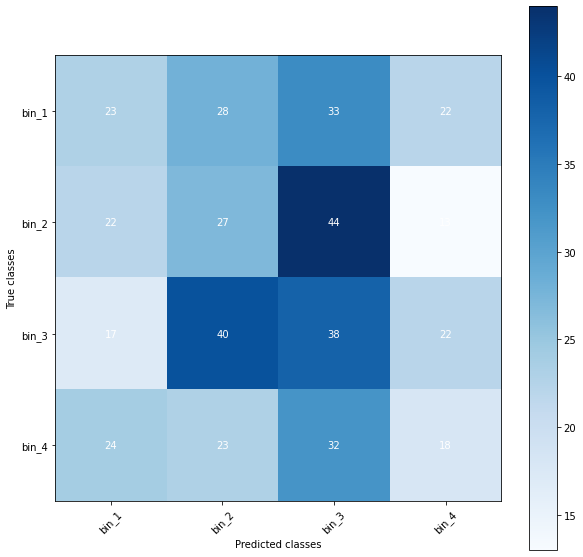

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Preprocess the Y_categorical data
encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y_categorical)
Y_encoded = to_categorical(Y_encoded)

bin_labels = ["bin_{}".format(i + 1) for i in range(n_bins)]

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_encoded, test_size=0.33, random_state=42)

# Define the model architecture
model = Sequential()
model.add(Dense(70, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5)),
model.add(Dense(34, activation='relu'))
model.add(Dropout(0.5)),
model.add(Dense(Y_encoded.shape[1], activation='tanh'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test loss: {:.4f}".format(test_loss))
print("Test accuracy: {:.4f}".format(test_accuracy))

# Plot the confusion matrix
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)
conf_mat = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.xlabel("Predicted classes")
plt.ylabel("True classes")
plt.xticks(np.arange(Y_encoded.shape[1]), bin_labels, rotation=45)
plt.yticks(np.arange(Y_encoded.shape[1]), bin_labels)
plt.colorbar()
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, conf_mat[i, j], ha="center", va="center", color="w")
plt.show()


In [159]:
Y_data[5:15]

array([ 0.1430464 , -0.11424707,  0.10837745,  0.38036478,  0.04622836,
       -0.03401958, -0.38813983,  0.06703076,  0.01319086, -0.01347103])

In [158]:
Y_categorical[5:15]

array(['bin_3', 'bin_1', 'bin_3', 'bin_3', 'bin_2', 'bin_1', 'bin_1',
       'bin_3', 'bin_2', 'bin_2'], dtype='<U5')

In [225]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, Y_pred, average=None)

# Create a table to display the results
results = pd.DataFrame({'Class': bin_labels, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score})
print(results)

   Class  Precision    Recall  F1 Score
0  bin_1   0.290598  0.320755  0.304933
1  bin_2   0.327273  0.339623  0.333333
2  bin_3   0.282051  0.188034  0.225641
3  bin_4   0.272727  0.340206  0.302752


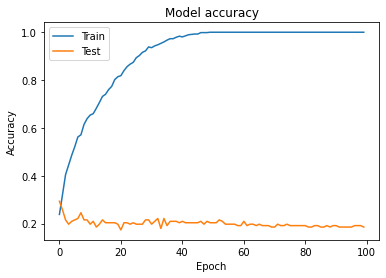

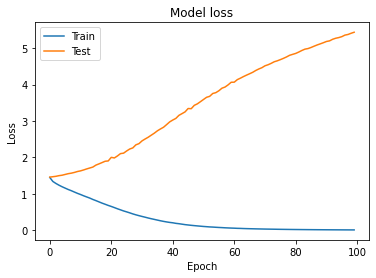

In [112]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot the training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

/Users/victor/miniforge3/envs/NLP_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


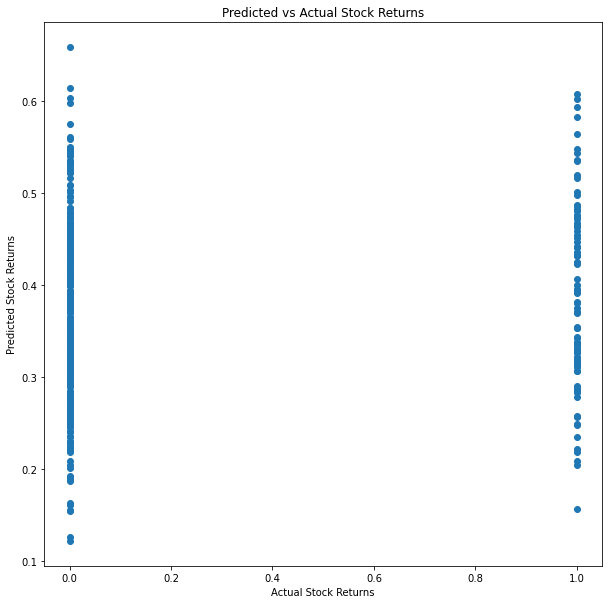

In [97]:
from sklearn.svm import SVR
model = SVR(kernel='rbf', C=1, epsilon=0.3)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_test)

plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Stock Returns")
plt.ylabel("Predicted Stock Returns")
plt.title("Predicted vs Actual Stock Returns")
plt.show()



In [90]:
print(X_data.shape)
print(Y_data.shape)

(987, 70)
(987,)


In [15]:
Y_data

array([ 0.23289604, -0.13685962,  0.40832962, ...,  0.06799316,
       -0.01983425,  0.06820767])

In [4]:
Y_dataCOPY = Y_data.copy()
X_dataCOPY = X_data.copy()
df = pd.DataFrame(Y_dataCOPY)
dfX = pd.DataFrame(X_dataCOPY)


# df[0] = np.where(df[0] < -0.4, -2,
#     np.where((df[0] >= -0.4) & (df[0] < -0.07), -1,
#     np.where((df[0] >= -0.07) & (df[0] <= 0.07), 0,
#     np.where((df[0] > 0.07) & (df[0] <= 0.4), 1, 2))))

df[0] = np.where(df[0] < -0.3, -1,
    np.where((df[0] >= -0.3) & (df[0] < 0.3), 0,
    np.where(df[0] >= 0.3, 1, df[0])))
    
Y_data_update = df.to_numpy()
X_data_update = dfX.to_numpy()

print(Y_data_update.shape)
print(X_data_update.shape)


(1703, 1)
(1703, 82)


In [5]:
print(Y_data_update.shape)
print(X_data_update.shape)


(1703, 1)
(1703, 82)


 4/26 [===>..........................] - ETA: 0s - loss: 0.9990

2023-02-09 09:48:03.271558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 4ms/step


2023-02-09 09:48:03.815480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


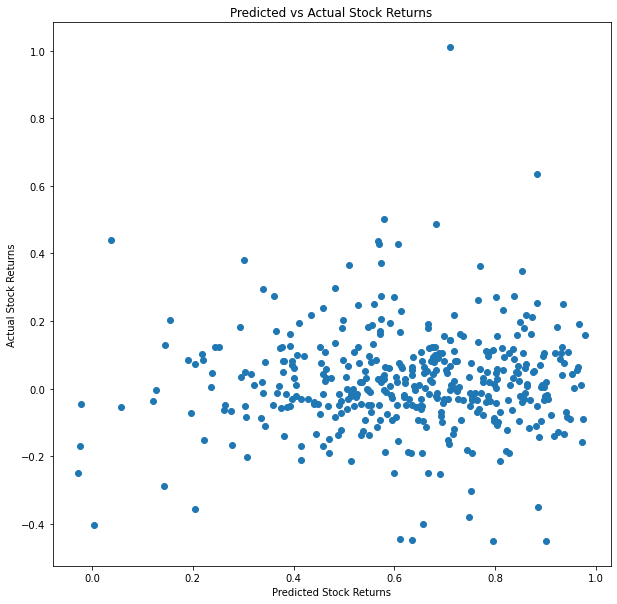

In [81]:
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(128, input_shape=(70,)))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('tanh'))

opt = SGD(lr=0.01, momentum=0.9)

model.compile(loss='hinge', optimizer=opt)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

plt.figure(figsize=(10,10))
plt.scatter(Y_pred, Y_test)
plt.ylabel("Actual Stock Returns")
plt.xlabel("Predicted Stock Returns")
plt.title("Predicted vs Actual Stock Returns")
plt.show()



Mean Squared Error:  0.02498468515265016
R2 Score:  -0.06333652696112213


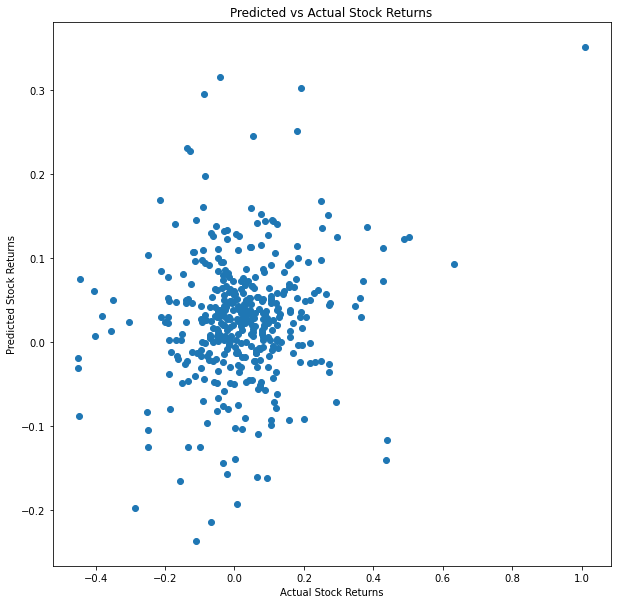

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the gradient boosting regressor
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=2,
    loss='squared_error',
    random_state=42
)

# Fit the regressor to the training data
gbr.fit(X_train, Y_train)

# Predict stock returns for the testing data
Y_pred = gbr.predict(X_test)

# Evaluate the performance of the model
from sklearn.metrics import mean_squared_error, r2_score
print("Mean Squared Error: ", mean_squared_error(Y_test, Y_pred))
print("R2 Score: ", r2_score(Y_test, Y_pred))

plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Stock Returns")
plt.ylabel("Predicted Stock Returns")
plt.title("Predicted vs Actual Stock Returns")
plt.show()



/var/folders/dr/g848f5b55mn9xp6p982hbg280000gn/T/ipykernel_40991/3087096297.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, Y_train)


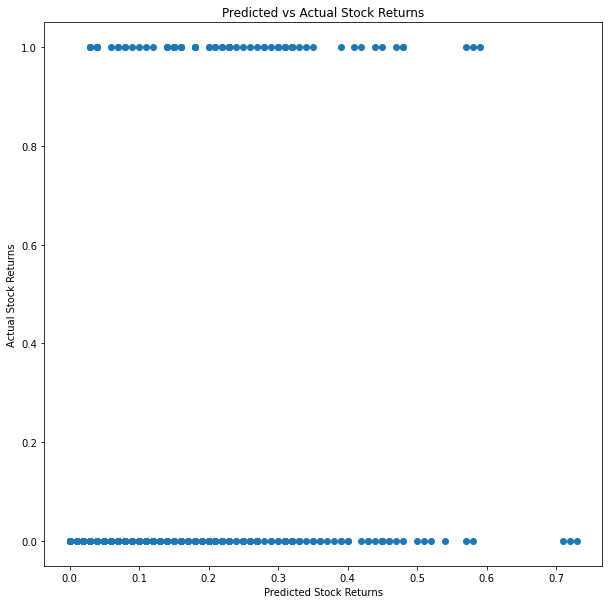

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train the Random Forest Regressor on the training data
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, Y_train)

# Predict the stock returns on the testing data
Y_pred = rf.predict(X_test)

plt.figure(figsize=(10,10))
plt.scatter(Y_pred, Y_test)
plt.ylabel("Actual Stock Returns")
plt.xlabel("Predicted Stock Returns")
plt.title("Predicted vs Actual Stock Returns")
plt.show()


Mean Squared Error: 0.20539722590685777


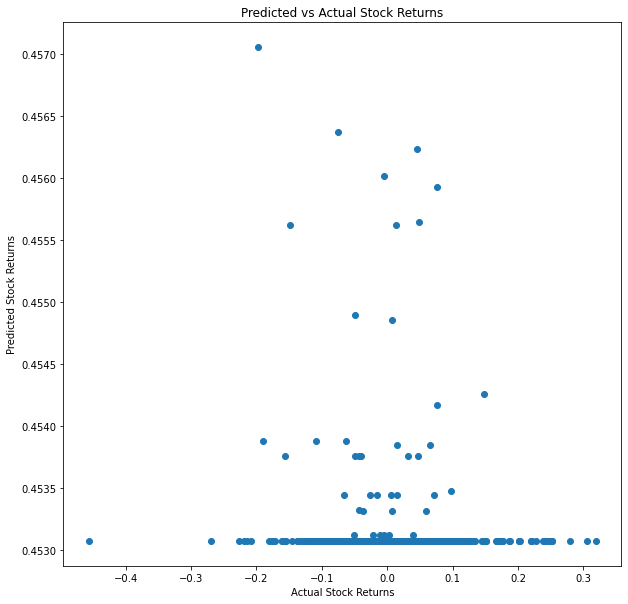

In [60]:
#promising RESULTS!!!

import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
sX_train, sX_test, sy_train, sy_test = train_test_split(X_data, Y_data, test_size=0.33, random_state=42)

# Convert training and testing data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(sX_train, label=sy_train)
dtest = xgb.DMatrix(sX_test, label=sy_test)

# Define hyperparameters for the XGBoost model
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'learning_rate': 0.001,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,    
    'n_jobs': -1,
    'random_state': 42
}

# Train the XGBoost model on the training data
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions on the test data
sy_pred = model.predict(dtest)

# Calculate the mean squared error
mse = mean_squared_error(sy_test, sy_pred)

# Print the mean squared error
print("Mean Squared Error:", mse)

import matplotlib.pyplot as plt

# Plot the predicted vs actual stock returns
plt.figure(figsize=(10,10))
plt.scatter(sy_test, sy_pred)
plt.xlabel("Actual Stock Returns")
plt.ylabel("Predicted Stock Returns")
plt.title("Predicted vs Actual Stock Returns")
plt.show()



Epoch 1/50


2023-02-08 22:58:51.931360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.6929

2023-02-08 22:58:53.051722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 46ms/step - loss: 0.2029 - accuracy: 0.6929 - val_loss: 0.2057 - val_accuracy: 0.7730
Epoch 2/50
21/21 [==============================] - 0s 21ms/step - loss: 0.1543 - accuracy: 0.8124 - val_loss: 0.1841 - val_accuracy: 0.7730
Epoch 3/50
21/21 [==============================] - 0s 17ms/step - loss: 0.1462 - accuracy: 0.8230 - val_loss: 0.1854 - val_accuracy: 0.7730
Epoch 4/50
21/21 [==============================] - 0s 16ms/step - loss: 0.1481 - accuracy: 0.8260 - val_loss: 0.1831 - val_accuracy: 0.7730
Epoch 5/50
21/21 [==============================] - 0s 15ms/step - loss: 0.1424 - accuracy: 0.8275 - val_loss: 0.1897 - val_accuracy: 0.7730
Epoch 6/50
21/21 [==============================] - 0s 19ms/step - loss: 0.1438 - accuracy: 0.8290 - val_loss: 0.1910 - val_accuracy: 0.7730
Epoch 7/50
21/21 [==============================] - 0s 17ms/step - loss: 0.1418 - accuracy: 0.8457 - val_loss: 0.1967 - val_accuracy: 0.7730
Epoch 8/50
21/21 [======

2023-02-08 22:59:09.339281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


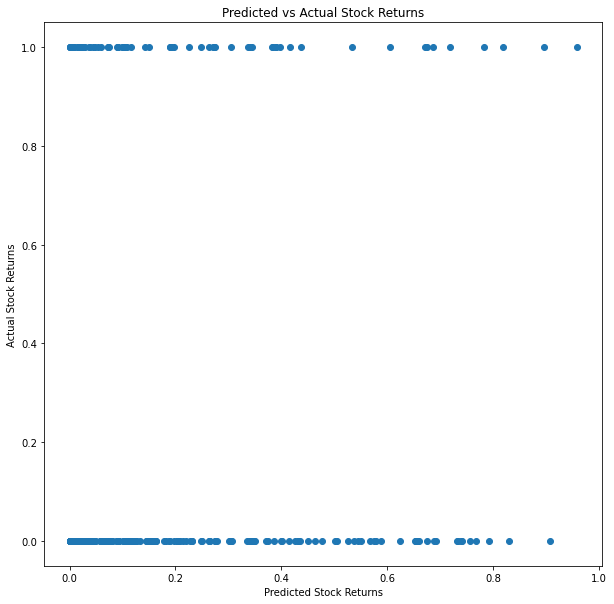

In [103]:
model = Sequential()

# Add the first hidden layer with 128 units and ReLU activation
model.add(Dense(250, activation='relu'))

# Add a dropout layer with a rate of 0.5 to prevent overfitting
model.add(Dropout(0.5))

model.add(Dense(200, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(160, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(120, activation='relu'))
# Add the second hidden layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add a dropout layer with a rate of 0.5 to prevent overfitting
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
# Add the output layer with a single unit and a linear activation
model.add(Dense(1, activation='sigmoid'))

# Compile the model with mean squared error loss and the Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

Y_pred = model.predict(X_test)

plt.figure(figsize=(10,10))
plt.scatter(Y_pred, Y_test)
plt.ylabel("Actual Stock Returns")
plt.xlabel("Predicted Stock Returns")
plt.title("Predicted vs Actual Stock Returns")
plt.show()


Epoch 1/100
 8/21 [==========>...................] - ETA: 0s - loss: 0.1564 

2023-02-08 22:52:24.177196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 16ms/step - loss: 0.1478 - val_loss: 0.2185
Epoch 2/100
17/21 [=======================>......] - ETA: 0s - loss: 0.1251

2023-02-08 22:52:24.517181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 10ms/step - loss: 0.1354 - val_loss: 0.1960
Epoch 3/100
21/21 [==============================] - 0s 11ms/step - loss: 0.1327 - val_loss: 0.2055
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 0.1292 - val_loss: 0.1894
Epoch 5/100
21/21 [==============================] - 0s 11ms/step - loss: 0.1278 - val_loss: 0.2024
Epoch 6/100
21/21 [==============================] - 0s 11ms/step - loss: 0.1288 - val_loss: 0.1802
Epoch 7/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1279 - val_loss: 0.1819
Epoch 8/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1380 - val_loss: 0.2130
Epoch 9/100
21/21 [==============================] - 0s 12ms/step - loss: 0.1342 - val_loss: 0.2123
Epoch 10/100
21/21 [==============================] - 0s 11ms/step - loss: 0.1255 - val_loss: 0.1855
Epoch 11/100
21/21 [==============================] - 0s 10ms/step - loss: 0.1279 - val_loss: 0.1891
Epoch 12/100

2023-02-08 22:52:43.158358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


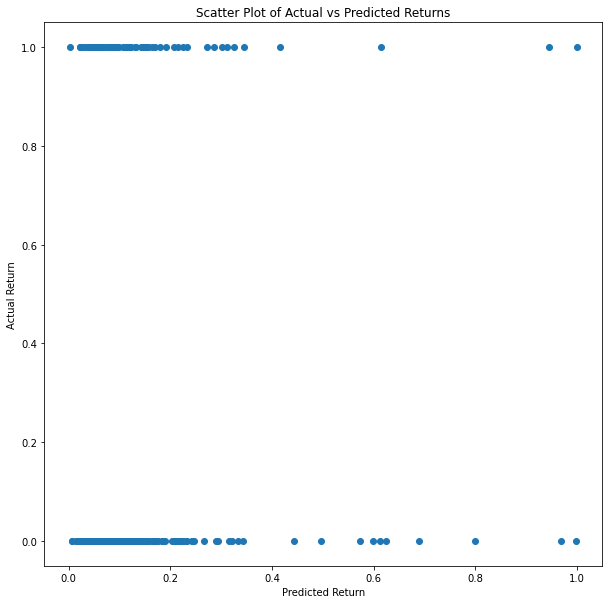

In [82]:
model = Sequential()
model.add(Dense(32, input_dim=70, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

# Make predictions on the test data
Y_pred = model.predict(X_test)

# Plot the results
plt.figure(figsize=(10,10))
plt.scatter(Y_pred, Y_test)
plt.ylabel('Actual Return')
plt.xlabel('Predicted Return')
plt.title('Scatter Plot of Actual vs Predicted Returns')
plt.show()

In [84]:
plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(Y_pred), max(Y_test))
p2 = min(min(Y_pred), min(Y_test))
plt.plot([0, p1], [0, p1])
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

NameError: name 'cY_test' is not defined

<Figure size 720x720 with 0 Axes>

MSE: 0.18
R2: -0.02


/Users/victor/miniforge3/envs/NLP_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


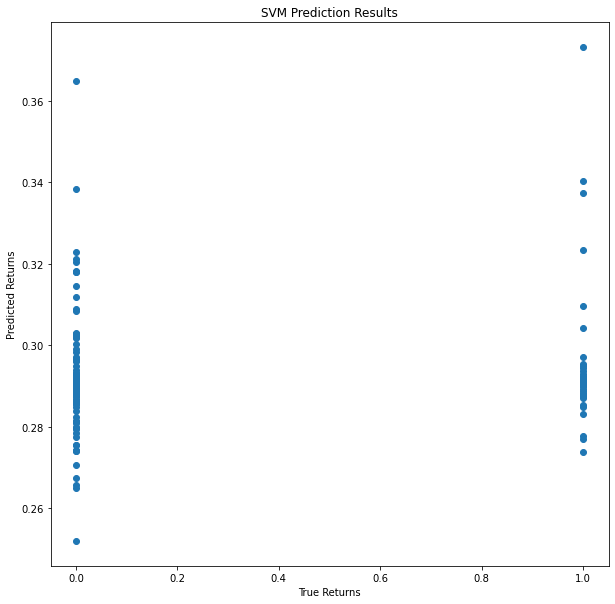

In [85]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
model = SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.2, tol=0.001, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'MSE: {mse:.2f}')
print(f'R2: {r2:.2f}')

# Plot the predictions against the actual returns
plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_pred)
plt.xlabel("True Returns")
plt.ylabel("Predicted Returns")
plt.title("SVM Prediction Results")
plt.show()

MSE: 0.18
R2: -0.16


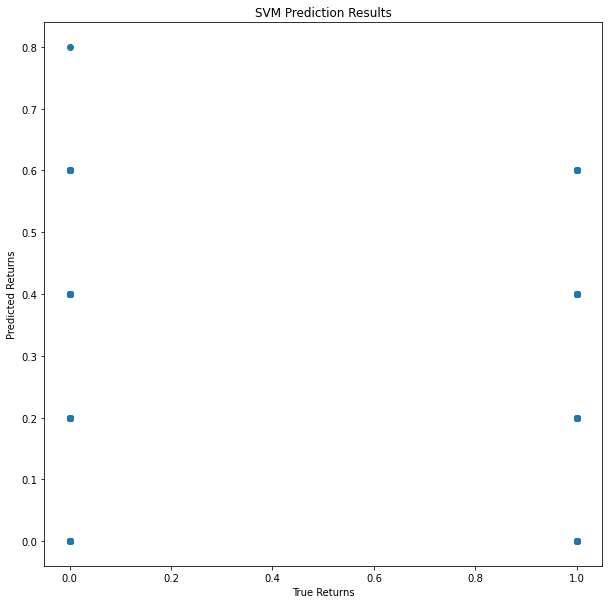

In [86]:
from sklearn.neighbors import KNeighborsRegressor


knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)
# mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'MSE: {mse:.2f}')
print(f'R2: {r2:.2f}')

# Plot the predictions against the actual returns
plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_pred)
plt.xlabel("True Returns")
plt.ylabel("Predicted Returns")
plt.title("SVM Prediction Results")
plt.show()

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt




Epoch 1/100


2023-02-08 22:53:23.791463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 1s 34ms/step - loss: 5.8449 - mse: 0.3154 - val_loss: 0.5724 - val_mse: 0.1868
Epoch 2/100
 1/21 [>.............................] - ETA: 0s - loss: 0.7269 - mse: 0.2142

2023-02-08 22:53:24.647557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 0s 15ms/step - loss: 1.1149 - mse: 0.2353 - val_loss: 0.5813 - val_mse: 0.1857
Epoch 3/100
21/21 [==============================] - 0s 14ms/step - loss: 1.2007 - mse: 0.2227 - val_loss: 0.5663 - val_mse: 0.1847
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 1.1271 - mse: 0.2391 - val_loss: 0.5686 - val_mse: 0.1859
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 0.8807 - mse: 0.2457 - val_loss: 0.5784 - val_mse: 0.1931
Epoch 6/100
21/21 [==============================] - 0s 13ms/step - loss: 0.9164 - mse: 0.2269 - val_loss: 0.5798 - val_mse: 0.1938
Epoch 7/100
21/21 [==============================] - 0s 13ms/step - loss: 0.7309 - mse: 0.2205 - val_loss: 0.5740 - val_mse: 0.1910
Epoch 8/100
21/21 [==============================] - 0s 18ms/step - loss: 0.8365 - mse: 0.2247 - val_loss: 0.5621 - val_mse: 0.1862
Epoch 9/100
21/21 [==============================] - 0s 17ms/step - loss: 0.7913 - mse: 

2023-02-08 22:53:56.128819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


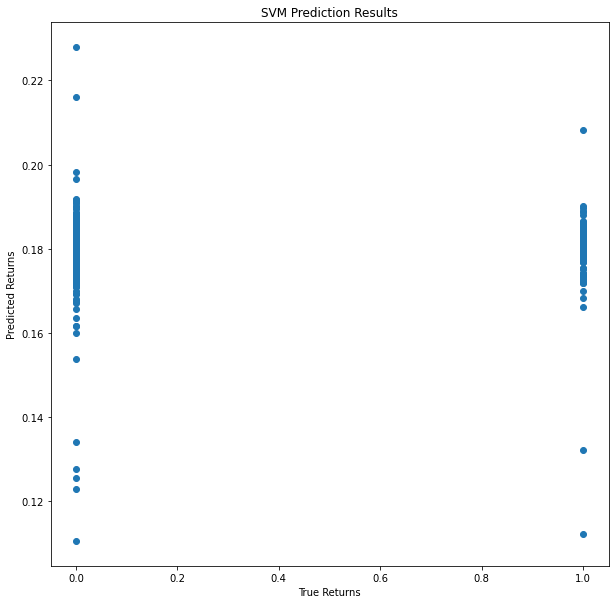

In [88]:
#DECENT MODEL!

model = Sequential()

# Add multiple hidden layers with different number of neurons
model.add(Dense(256, activation='relu', input_shape=(70,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.8))
# Add the output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

Y_pred = model.predict(X_test)
plt.figure(figsize=(10,10))
plt.scatter(Y_test, Y_pred)
plt.xlabel("True Returns")
plt.ylabel("Predicted Returns")
plt.title("SVM Prediction Results")
plt.show()

In [ ]:
regr = DecisionTreeRegressor(random_state=0)


In [592]:
from sklearn.metrics import classification_report

# Make predictions on the test data
Y_pred = model.predict(X_test)

# Convert predictions to binary format (0 or 1)
Y_pred = np.round(Y_pred)

# Generate classification report
print(classification_report(Y_test, Y_pred))


9/9 [==============================] - 0s 4ms/step


ValueError: Classification metrics can't handle a mix of continuous and multiclass targets

In [694]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics

rfc = RandomForestClassifier(n_estimators=1000)

rfc.fit(X_train, Y_train)
score = rfc.score(X_test, Y_test)
Y_pred = rfc.predict(X_test)

print(metrics.classification_report(Y_test, Y_pred))


ValueError: Unknown label type: 'continuous'

In [222]:
from sklearn.metrics import fbeta_score


f2_score = fbeta_score(Y_test, Y_pred, beta=2, average='macro')
print('F2 score: ', f2_score)

F2 score:  0.9126984126984127


In [82]:
new_Y_data = []

In [76]:
# 0.05232749576968998
arr = [[2,3,4], [5,None,3]]
a = remove_none_types(Y_data)
# print(a)

                     2022
85  -0.051724136025191325
86   -0.02390602690140997
87    -0.1525644085301101
88    0.05288324693428659
89    0.14358163060132378
90   0.022336775697576527
91                    NaN
92   -0.08637918235815045
93     0.1351140577858143
94    0.23289603942402248
                     2022
85    0.23308270676691722
86  0.0010526269898378793
87   -0.06075189346657661
88   -0.06781952363207822
89    0.01097749408922688
90   0.052766730550235286
91   -0.14533315937255797
92   -0.19809988992279315
93    -0.2041340073921576
94    -0.1368596240370693
                     2022
85  -0.030644177262782568
86    0.07629768093131739
87   0.009589307333061514
88    0.16447778171502803
89      0.332290978133841
90   0.024680451862564956
91    0.13772586718582858
92    0.06721020637444464
93     0.2309387240098537
94    0.40832962413296126
                    2021
85  -0.15756704419921852
86  -0.17900078028648514
87  -0.32570602005055616
88  -0.34482259697285966
89   -0.247212204